# House Price Prediction

## Problem Statement

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.<br/> 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

## Business Goal 

- Identify variables which are significant in predicting the price of a house
- How well those variables describe the price of a house.

In [687]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import r2_score, mean_squared_error

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [549]:
# Reading the data from csv file
house_price=pd.read_csv('train.csv')

In [550]:
#Looking at the dataset
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Data cleaning

### Removing the columns which has more than 90% of the values as null

In [551]:
# finding the columns with 90% of values as null
missing_columns = house_price.columns[100*(house_price.isnull().sum()/len(house_price.index)) > 90]
print(missing_columns)

Index(['Alley', 'PoolQC', 'MiscFeature'], dtype='object')


In [552]:
# dropping the missing columns
house_price=house_price.drop(columns=missing_columns,axis=1)

In [553]:
# checking if there are any other columns with more than 90% null values
house_price.columns[100*(house_price.isnull().sum()/len(house_price.index)) > 90]

Index([], dtype='object')

In [554]:
# converting the columns as object as the values are of category typee
house_price['OverallQual'] = house_price['OverallQual'].astype('object')
house_price['OverallCond'] = house_price['OverallCond'].astype('object')
house_price['MSSubClass'] = house_price['MSSubClass'].astype('object')

In [555]:
# Analyzing the given data
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   object 
 17  OverallCond    1460 non-null   object 
 18  YearBuil

## Imputing null values

### Filling the data which is missing for some columns

In [556]:
#Finding the percent of values missing at the column level
missing_cat_obj_null_prcnt = round(100*house_price.isnull().sum()/len(house_price.index),2)
missing_cat_obj_null_prcnt = missing_cat_obj_null_prcnt[missing_cat_obj_null_prcnt!=0]
missing_cat_obj_null_prcnt

LotFrontage     17.74
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
Fence           80.75
dtype: float64

In [557]:
#listing the columns which are missing the values 
missing_data_columns=house_price.columns[100*(house_price.isnull().sum()/len(house_price.index)) > 0]
missing_data_columns

Index(['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'Fence'],
      dtype='object')

In [558]:
# Filling the null values with a logic of considering None for some columns as NA is considered of no for a feature
# not available case, 0 for numeric columns based on the percentile values.
house_price['LotFrontage']=house_price['LotFrontage'].fillna(0.0)
house_price['MasVnrType']=house_price['MasVnrType'].fillna('None')
house_price['MasVnrArea']=house_price['MasVnrArea'].fillna(0.0)
house_price['BsmtQual']=house_price['BsmtQual'].fillna('None')
house_price['BsmtCond']=house_price['BsmtCond'].fillna('None')
house_price['BsmtExposure']=house_price['BsmtExposure'].fillna('None')
house_price['BsmtFinType1']=house_price['BsmtFinType1'].fillna('None')
house_price['BsmtFinType2']=house_price['BsmtFinType2'].fillna('None')
house_price['Electrical']=house_price['Electrical'].fillna('SBrkr')
house_price['FireplaceQu']=house_price['FireplaceQu'].fillna('None')
house_price['GarageType']=house_price['GarageType'].fillna('None')
house_price['GarageYrBlt']=house_price['GarageYrBlt'].fillna(0)
house_price['GarageFinish']=house_price['GarageFinish'].fillna('None')
house_price['GarageQual']=house_price['GarageQual'].fillna('None')
house_price['GarageCond']=house_price['GarageCond'].fillna('None')
house_price['Fence']=house_price['Fence'].fillna('None')

In [559]:
# checking the columns for a missing value.
missing_data_columns=house_price.columns[100*(house_price.isnull().sum()/len(house_price.index)) > 0]
missing_data_columns

Index([], dtype='object')

In [560]:
# re-checking the dataset
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   object 
 17  OverallCond    1460 non-null   object 
 18  YearBuil

## Droping the columns which have very high number of single values

In [561]:
# Finding the list of columns in which the value counts of a value will be very high.
# Dropping if that column's value_count exceeds 80% of any column
skewed_data_cols=[]
num_rows = len(house_price)

for col in house_price.columns:
    cnts = house_price[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.80:
        skewed_data_cols.append(col)
skewed_data_cols

['Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'RoofMatl',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'BsmtFinSF2',
 'Heating',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'Fence',
 'MiscVal',
 'SaleType',
 'SaleCondition']

In [562]:
# Dropping the columns with the skewed data
house_price=house_price.drop(columns=skewed_data_cols,axis=1)

In [563]:
# chceking the dataset after dropping the columns
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 48 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            1460 non-null   int64  
 1   MSSubClass    1460 non-null   object 
 2   MSZoning      1460 non-null   object 
 3   LotFrontage   1460 non-null   float64
 4   LotArea       1460 non-null   int64  
 5   LotShape      1460 non-null   object 
 6   LotConfig     1460 non-null   object 
 7   Neighborhood  1460 non-null   object 
 8   HouseStyle    1460 non-null   object 
 9   OverallQual   1460 non-null   object 
 10  OverallCond   1460 non-null   object 
 11  YearBuilt     1460 non-null   int64  
 12  YearRemodAdd  1460 non-null   int64  
 13  RoofStyle     1460 non-null   object 
 14  Exterior1st   1460 non-null   object 
 15  Exterior2nd   1460 non-null   object 
 16  MasVnrType    1460 non-null   object 
 17  MasVnrArea    1460 non-null   float64
 18  ExterQual     1460 non-null 

In [564]:
# looking at the numeric columns
house_price_numeric = house_price.select_dtypes(include=['float64', 'int64'])
house_price_numeric.head()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
0,1,65.0,8450,2003,2003,196.0,706,150,856,856,...,8,0,2003.0,2,548,0,61,2,2008,208500
1,2,80.0,9600,1976,1976,0.0,978,284,1262,1262,...,6,1,1976.0,2,460,298,0,5,2007,181500
2,3,68.0,11250,2001,2002,162.0,486,434,920,920,...,6,1,2001.0,2,608,0,42,9,2008,223500
3,4,60.0,9550,1915,1970,0.0,216,540,756,961,...,7,1,1998.0,3,642,0,35,2,2006,140000
4,5,84.0,14260,2000,2000,350.0,655,490,1145,1145,...,9,1,2000.0,3,836,192,84,12,2008,250000


In [565]:
house_price_numeric.columns

Index(['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold',
       'YrSold', 'SalePrice'],
      dtype='object')

### Looking at each numeric column to check for outliers

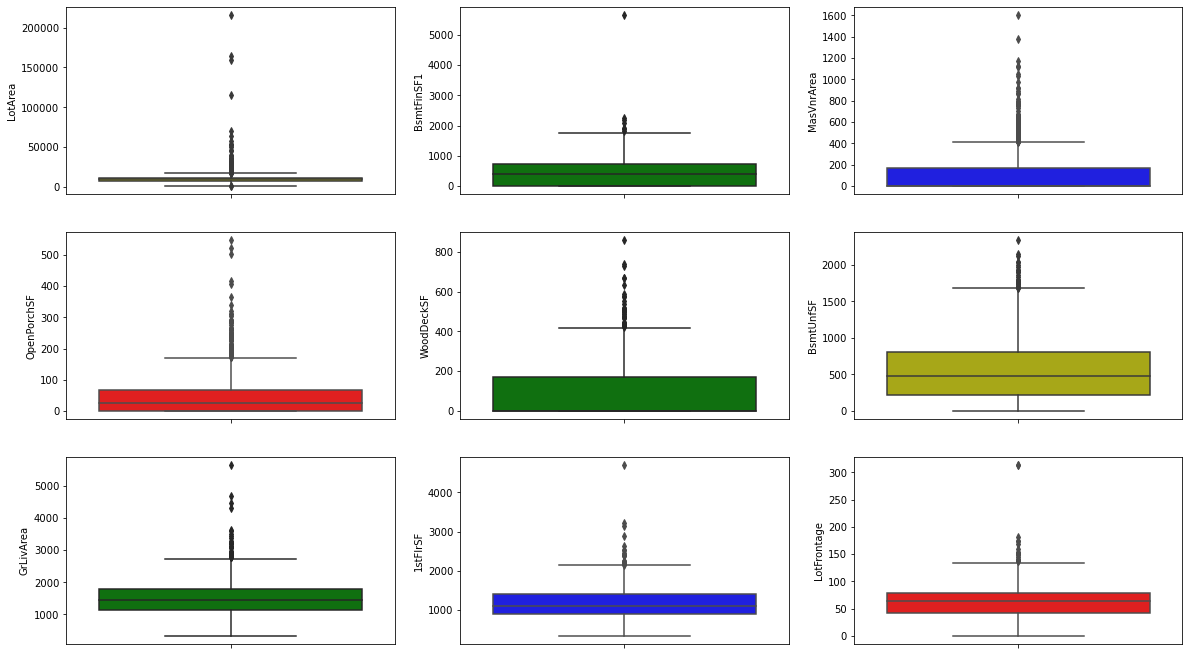

In [566]:
plt.figure(figsize=(20, 20))
plt.subplot(5,3,1)
sns.boxplot(y = 'LotArea', color='y', data = house_price)
plt.subplot(5,3,2)
sns.boxplot(y = 'BsmtFinSF1', color='g', data = house_price)
plt.subplot(5,3,3)
sns.boxplot(y = 'MasVnrArea', color='b', data = house_price)
plt.subplot(5,3,4)
sns.boxplot(y = 'OpenPorchSF', color='r', data = house_price)
plt.subplot(5,3,5)
sns.boxplot(y = 'WoodDeckSF', color='g', data = house_price)
plt.subplot(5,3,6)
sns.boxplot(y = 'BsmtUnfSF', color='y', data = house_price)
plt.subplot(5,3,7)
sns.boxplot(y = 'GrLivArea', color='g', data = house_price)
plt.subplot(5,3,8)
sns.boxplot(y = '1stFlrSF', color='b', data = house_price)
plt.subplot(5,3,9)
sns.boxplot(y = 'LotFrontage', color='r', data = house_price)

plt.show()

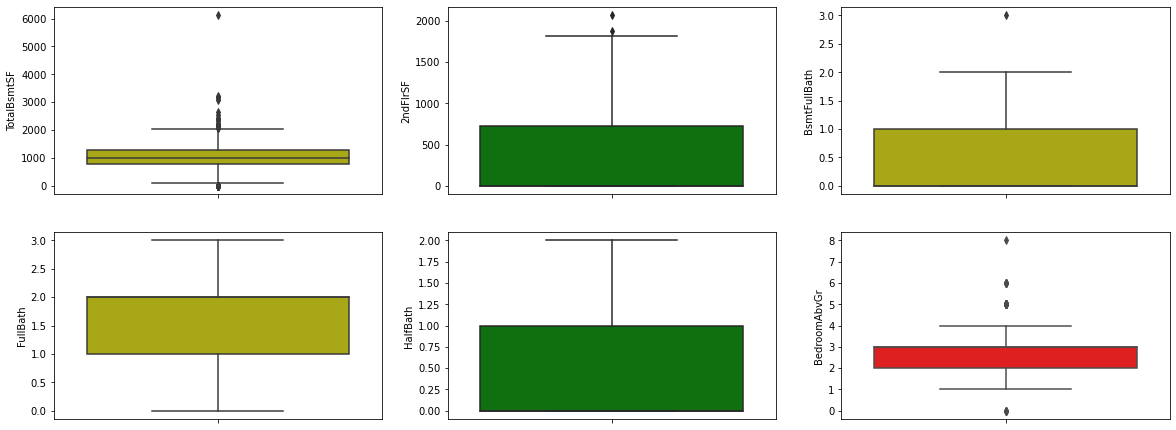

In [567]:
plt.figure(figsize=(20, 20))
plt.subplot(5,3,1)
sns.boxplot(y = 'TotalBsmtSF', color='y', data = house_price)
plt.subplot(5,3,2)
sns.boxplot(y = '2ndFlrSF', color='g', data = house_price)
plt.subplot(5,3,3)
sns.boxplot(y = 'BsmtFullBath', color='y', data = house_price)
plt.subplot(5,3,4)
sns.boxplot(y = 'FullBath', color='y', data = house_price)
plt.subplot(5,3,5)
sns.boxplot(y = 'HalfBath', color='g', data = house_price)
plt.subplot(5,3,6)
sns.boxplot(y = 'BedroomAbvGr', color='r', data = house_price)
plt.show()

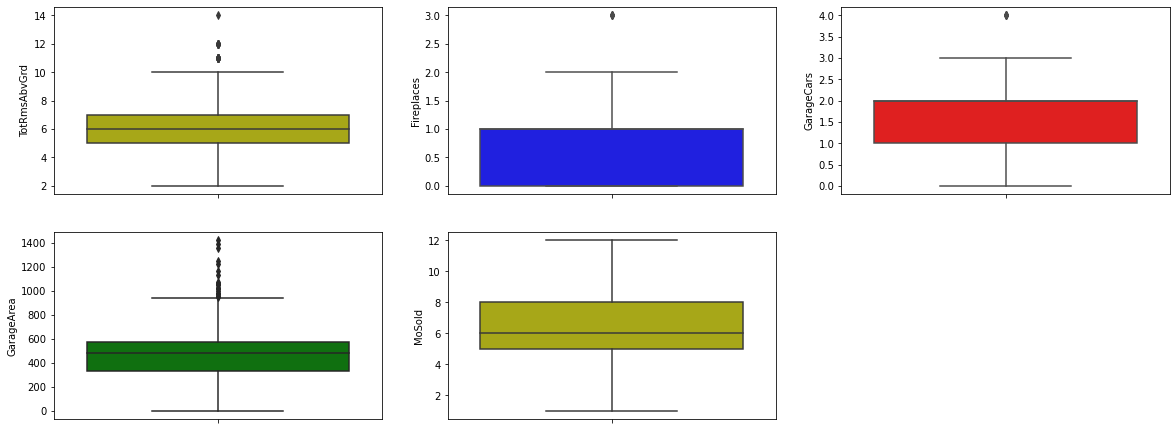

In [568]:
plt.figure(figsize=(20, 20))
plt.subplot(5,3,1)
sns.boxplot(y = 'TotRmsAbvGrd', color='y', data = house_price)
plt.subplot(5,3,2)
sns.boxplot(y = 'Fireplaces', color='b', data = house_price)
plt.subplot(5,3,3)
sns.boxplot(y = 'GarageCars', color='r', data = house_price)
plt.subplot(5,3,4)
sns.boxplot(y = 'GarageArea', color='g', data = house_price)
plt.subplot(5,3,5)
sns.boxplot(y = 'MoSold', color='y', data = house_price)
plt.show()

In [569]:
# Removing the rows which fall above the 98 percentile of the nuermic columns
for feature in house_price_numeric.columns:
    feature_quantile_value = house_price[feature].quantile(0.98)
    house_price = house_price[house_price[feature] <= feature_quantile_value]

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

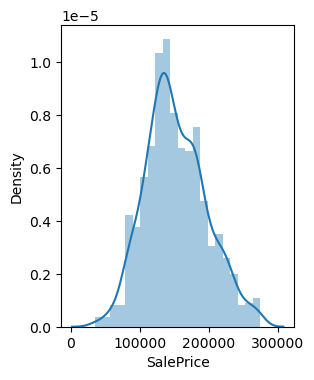

In [570]:
plt.figure(figsize=(3,4), dpi=100)
sns.distplot(house_price['SalePrice'])

In [571]:
# updating the numeric dataframe from the initial dataframe as the outlier treatment is done in house_price dataset
house_price_numeric = house_price.select_dtypes(include=['float64', 'int64'])
house_price_numeric.head()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
0,1,65.0,8450,2003,2003,196.0,706,150,856,856,...,8,0,2003.0,2,548,0,61,2,2008,208500
1,2,80.0,9600,1976,1976,0.0,978,284,1262,1262,...,6,1,1976.0,2,460,298,0,5,2007,181500
2,3,68.0,11250,2001,2002,162.0,486,434,920,920,...,6,1,2001.0,2,608,0,42,9,2008,223500
3,4,60.0,9550,1915,1970,0.0,216,540,756,961,...,7,1,1998.0,3,642,0,35,2,2006,140000
4,5,84.0,14260,2000,2000,350.0,655,490,1145,1145,...,9,1,2000.0,3,836,192,84,12,2008,250000


In [572]:
# Dropping the Id column
house_price_numeric = house_price_numeric.drop(['Id'], axis=1)
house_price_numeric.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
0,65.0,8450,2003,2003,196.0,706,150,856,856,854,...,8,0,2003.0,2,548,0,61,2,2008,208500
1,80.0,9600,1976,1976,0.0,978,284,1262,1262,0,...,6,1,1976.0,2,460,298,0,5,2007,181500
2,68.0,11250,2001,2002,162.0,486,434,920,920,866,...,6,1,2001.0,2,608,0,42,9,2008,223500
3,60.0,9550,1915,1970,0.0,216,540,756,961,756,...,7,1,1998.0,3,642,0,35,2,2006,140000
4,84.0,14260,2000,2000,350.0,655,490,1145,1145,1053,...,9,1,2000.0,3,836,192,84,12,2008,250000


In [573]:
# listing the numeric columns
house_price_numeric.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [574]:
# looking at the shape of the dataset
house_price_numeric.shape

(1021, 25)

In [575]:
# calculating the correlation matrix fo rthe numeric columns
cor = house_price_numeric.corr()
cor

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
LotFrontage,1.000000,0.218033,-0.080502,-0.028965,-0.068126,-0.054871,0.141908,0.111388,0.152148,-0.036120,...,0.142248,-0.048899,0.011231,0.029009,0.072923,-0.074518,0.000948,0.002518,-0.039155,0.051940
LotArea,0.218033,1.000000,0.016027,-0.043818,0.018470,0.138325,0.027595,0.199206,0.302871,0.054253,...,0.296107,0.227275,0.128799,0.166845,0.220606,0.099257,0.092528,0.021198,-0.014200,0.314436
YearBuilt,-0.080502,0.016027,1.000000,0.571610,0.219294,0.214480,0.096866,0.340089,0.247345,0.044141,...,0.077996,0.105983,0.262327,0.524836,0.464538,0.243591,0.265236,0.001775,-0.035077,0.616466
YearRemodAdd,-0.028965,-0.043818,0.571610,1.000000,0.034317,0.073515,0.136047,0.218227,0.140297,0.134551,...,0.130354,0.020422,0.126015,0.371183,0.309937,0.218191,0.229879,0.009869,0.032919,0.530292
MasVnrArea,-0.068126,0.018470,0.219294,0.034317,1.000000,0.181317,0.014268,0.193911,0.195086,0.068884,...,0.133954,0.181787,0.109051,0.191277,0.189161,0.092486,0.096528,-0.028322,0.020054,0.246630
BsmtFinSF1,-0.054871,0.138325,0.214480,0.073515,0.181317,1.000000,-0.585126,0.371049,0.275280,-0.214779,...,-0.102676,0.121348,0.114852,0.136083,0.198144,0.152850,0.045699,-0.008792,0.024578,0.261126
BsmtUnfSF,0.141908,0.027595,0.096866,0.136047,0.014268,-0.585126,1.000000,0.454997,0.313690,-0.012944,...,0.214524,0.074779,0.056335,0.150850,0.109304,-0.051225,0.080281,0.034810,-0.060541,0.193842
TotalBsmtSF,0.111388,0.199206,0.340089,0.218227,0.193911,0.371049,0.454997,1.000000,0.714951,-0.299641,...,0.120356,0.218509,0.209994,0.328608,0.362590,0.140609,0.137308,0.027167,-0.022982,0.516307
1stFlrSF,0.152148,0.302871,0.247345,0.140297,0.195086,0.275280,0.313690,0.714951,1.000000,-0.403032,...,0.238066,0.276400,0.170352,0.332626,0.369713,0.138690,0.091765,0.032609,-0.013440,0.458327
2ndFlrSF,-0.036120,0.054253,0.044141,0.134551,0.068884,-0.214779,-0.012944,-0.299641,-0.403032,1.000000,...,0.588548,0.182879,0.096720,0.151109,0.078771,0.011961,0.251703,0.033274,-0.002825,0.337102


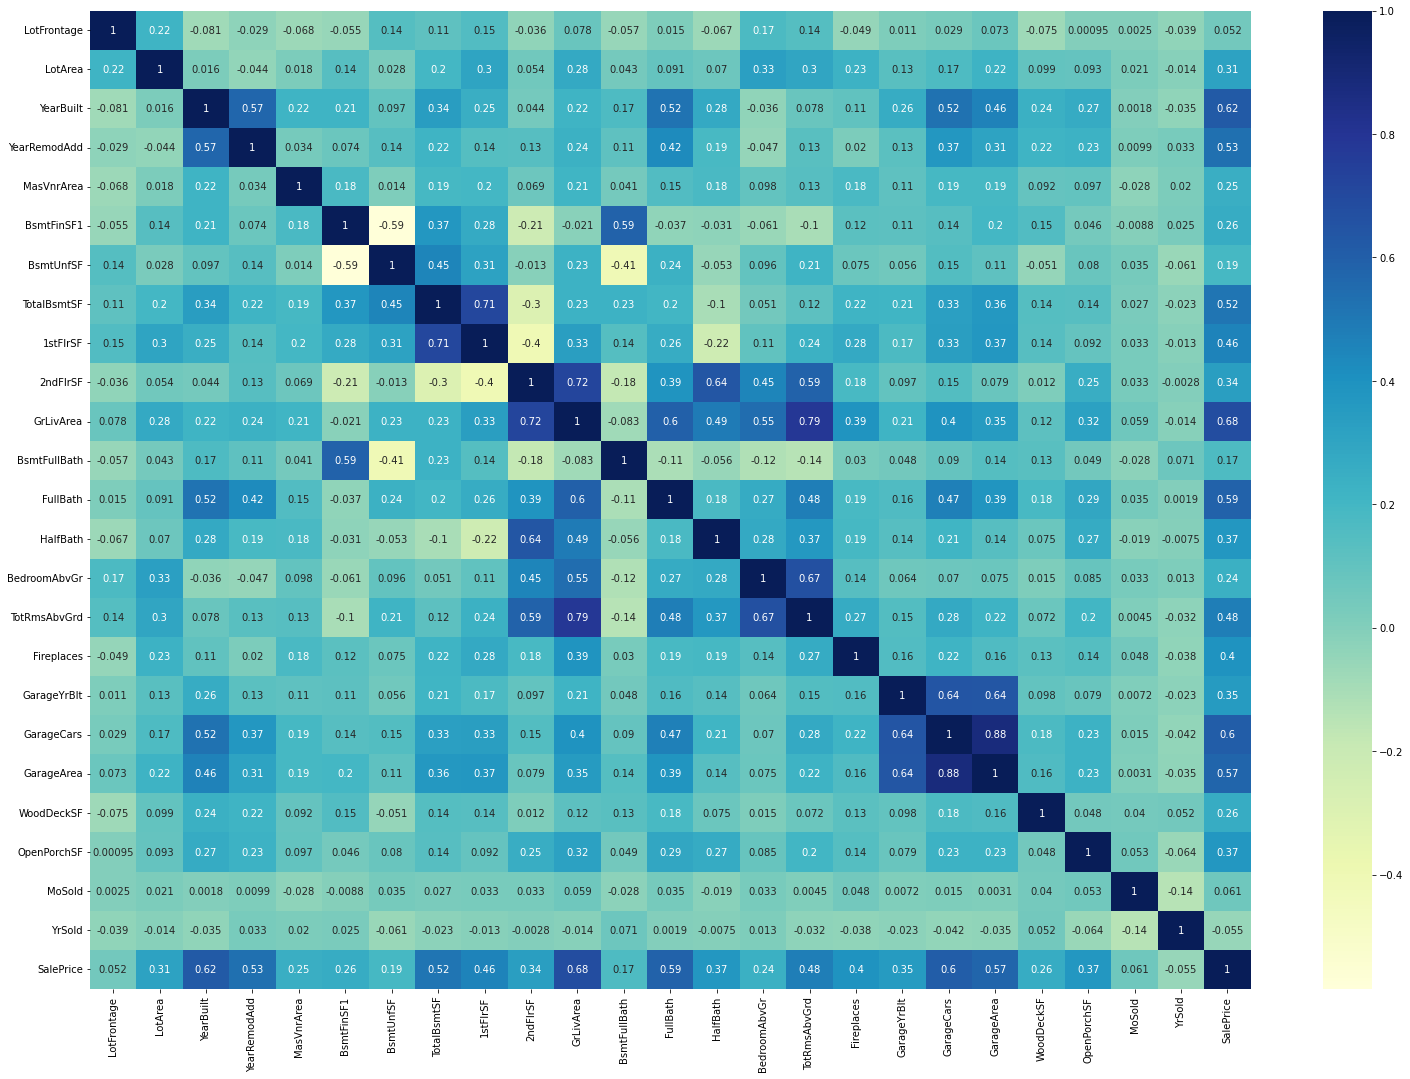

In [576]:
# plotting the heatmap of the numeric columns
plt.figure(figsize=(26,18))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

### Analyzing the numeric columns relation with sale price column

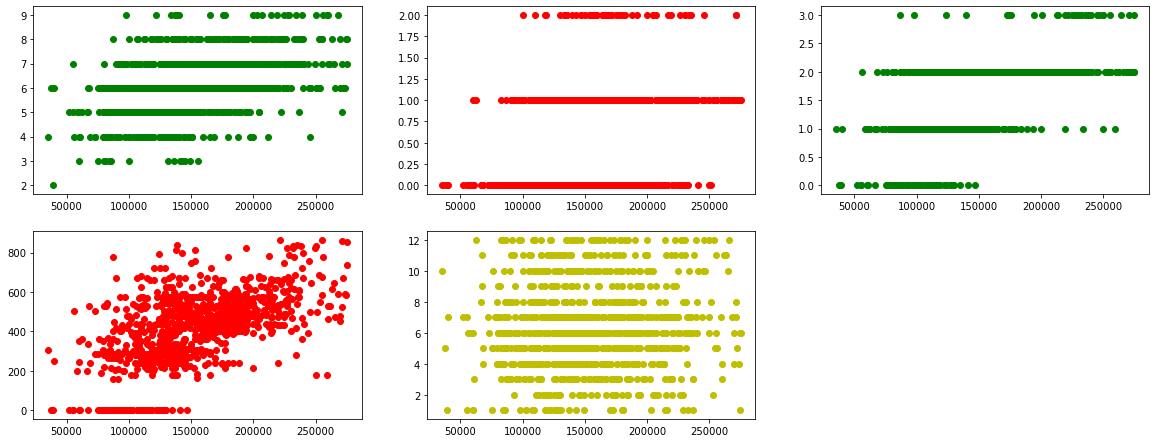

In [577]:
plt.figure(figsize=(20, 20))
plt.subplot(5,3,1)
plt.scatter(x='SalePrice',y = 'TotRmsAbvGrd', color='g', data = house_price)
plt.subplot(5,3,2)
plt.scatter(x='SalePrice',y = 'Fireplaces', color='r', data = house_price)
plt.subplot(5,3,3)
plt.scatter(x='SalePrice',y = 'GarageCars', color='g', data = house_price)
plt.subplot(5,3,4)
plt.scatter(x='SalePrice',y = 'GarageArea', color='r', data = house_price)
plt.subplot(5,3,5)
plt.scatter(x='SalePrice',y = 'MoSold', color='y', data = house_price)
plt.show()

### Observation:

#### GarageArea has a linear relationship with SalePrice column

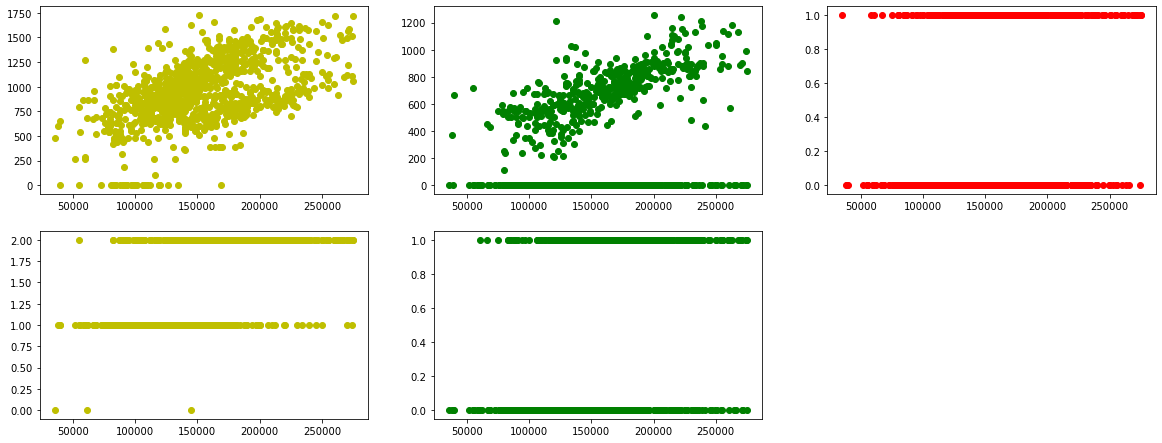

In [578]:
plt.figure(figsize=(20, 20))
plt.subplot(5,3,1)
plt.scatter(x='SalePrice',y = 'TotalBsmtSF', color='y', data = house_price)
plt.subplot(5,3,2)
plt.scatter(x='SalePrice',y = '2ndFlrSF', color='g', data = house_price)
plt.subplot(5,3,3)
plt.scatter(x='SalePrice',y = 'BsmtFullBath', color='r', data = house_price)
plt.subplot(5,3,4)
plt.scatter(x='SalePrice',y = 'FullBath', color='y', data = house_price)
plt.subplot(5,3,5)
plt.scatter(x='SalePrice',y = 'HalfBath', color='g', data = house_price)
plt.show()


### Observation:

#### TotalBsmtSF and 2ndFlrSF has a linear relationship with SalePrice column

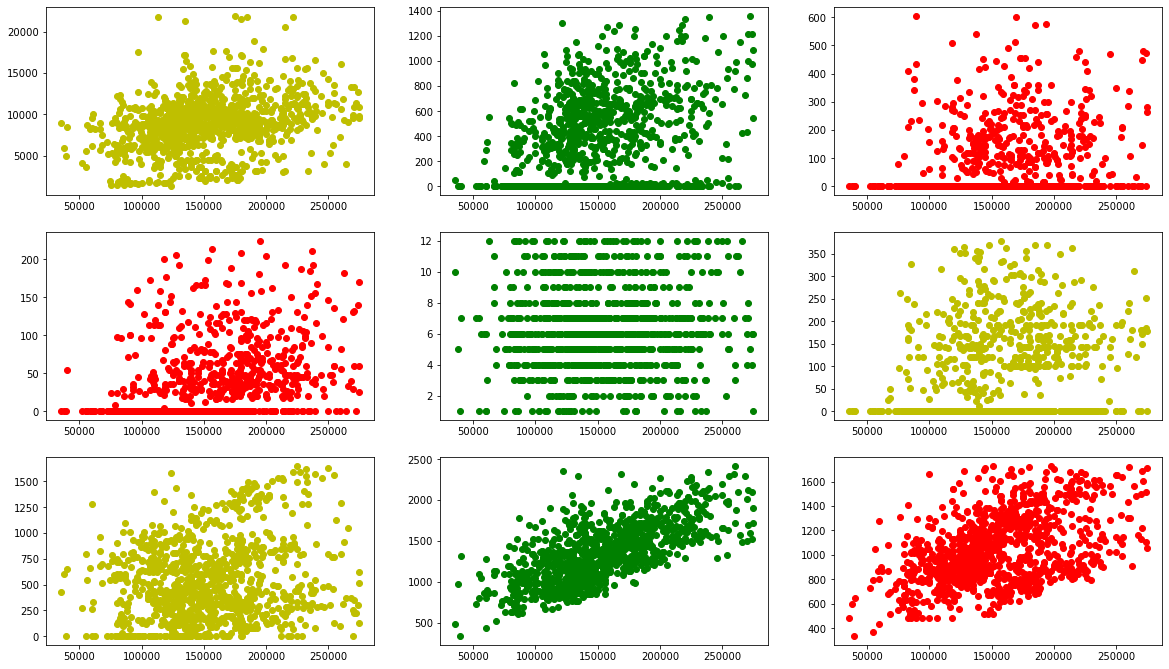

In [579]:
plt.figure(figsize=(20, 20))
plt.subplot(5,3,1)
plt.scatter(x='SalePrice',y = 'LotArea', color='y', data = house_price)
plt.subplot(5,3,2)
plt.scatter(x='SalePrice',y = 'BsmtFinSF1', color='g', data = house_price)
plt.subplot(5,3,3)
plt.scatter(x='SalePrice',y = 'MasVnrArea', color='r', data = house_price)
plt.subplot(5,3,4)
plt.scatter(x='SalePrice',y = 'OpenPorchSF', color='r', data = house_price)
plt.subplot(5,3,5)
plt.scatter(x='SalePrice',y = 'MoSold', color='g', data = house_price)
plt.subplot(5,3,6)
plt.scatter(x='SalePrice',y = 'WoodDeckSF', color='y', data = house_price)
plt.subplot(5,3,7)
plt.scatter(x='SalePrice',y = 'BsmtUnfSF', color='y', data = house_price)
plt.subplot(5,3,8)
plt.scatter(x='SalePrice',y = 'GrLivArea', color='g', data = house_price)
plt.subplot(5,3,9)
plt.scatter(x='SalePrice',y = '1stFlrSF', color='r', data = house_price)

plt.show()

### Observation:

#### GrLivArea and 1stFlrSF has a linear relationship with SalePrice column

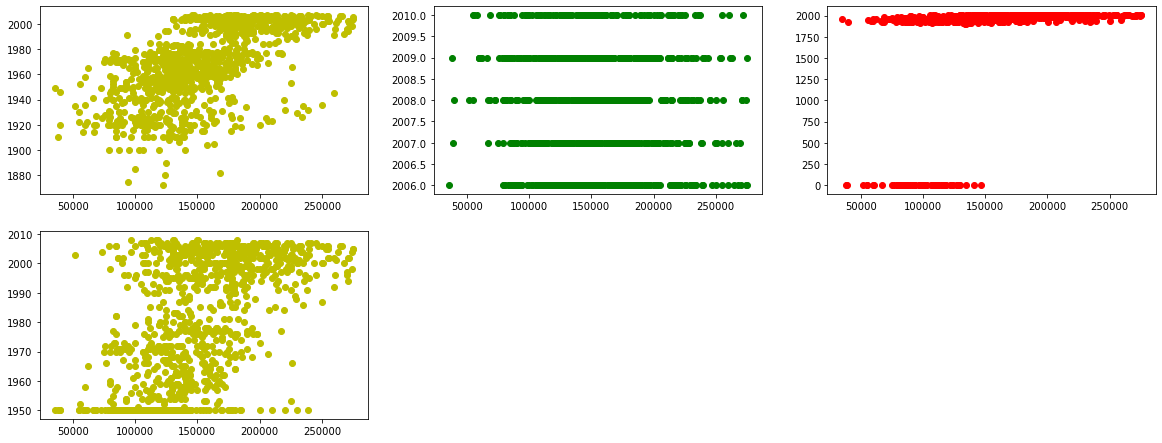

In [580]:
plt.figure(figsize=(20, 20))
plt.subplot(5,3,1)
plt.scatter(x='SalePrice',y = 'YearBuilt', color='y', data = house_price)
plt.subplot(5,3,2)
plt.scatter(x='SalePrice',y = 'YrSold', color='g', data = house_price)
plt.subplot(5,3,3)
plt.scatter(x='SalePrice',y = 'GarageYrBlt', color='r', data = house_price)
plt.subplot(5,3,4)
plt.scatter(x='SalePrice',y = 'YearRemodAdd', color='y', data = house_price)

plt.show()

### Observation:

#### YearBuilt has a linear relationship with SalePrice column

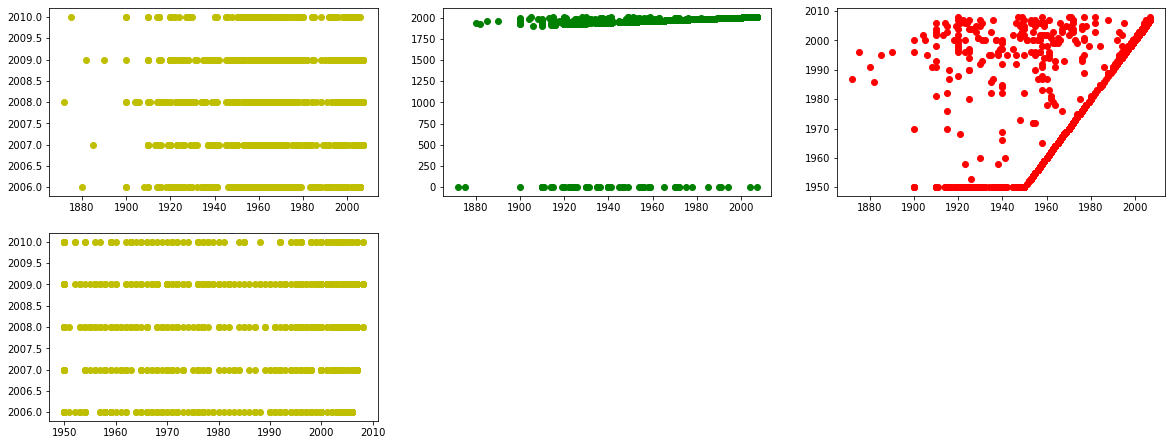

In [581]:
plt.figure(figsize=(20, 20))
plt.subplot(5,3,1)
plt.scatter(x='YearBuilt',y = 'YrSold', color='y', data = house_price)
plt.subplot(5,3,2)
plt.scatter(x='YearBuilt',y = 'GarageYrBlt', color='g', data = house_price)
plt.subplot(5,3,3)
plt.scatter(x='YearBuilt',y = 'YearRemodAdd', color='r', data = house_price)
plt.subplot(5,3,4)
plt.scatter(x='YearRemodAdd',y = 'YrSold', color='y', data = house_price)

plt.show()

In [582]:
# create a new column with a dervived value of how old the house is 
house_price['houseAge']=house_price['YrSold']-house_price['YearBuilt']

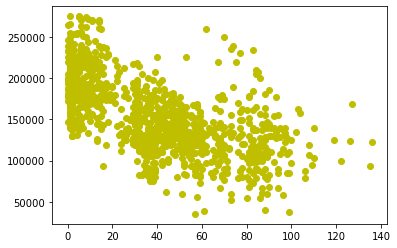

In [583]:
plt.scatter(x='houseAge',y = 'SalePrice', color='y', data = house_price)
plt.show()

In [584]:
### Dropping year related columns 
house_price=house_price.drop(columns=['YearBuilt','YrSold','GarageYrBlt','YearRemodAdd'],axis=1)

### Analyzing the categorical columns

In [585]:
#Mapping the ordered categorical column values 
house_price['LotShape_cat'] = house_price[['LotShape']].apply(lambda x: x.map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}))
house_price['ExterQual_cat'] = house_price[['ExterQual']].apply(lambda x: x.map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 }))
house_price['BsmtQual_cat'] = house_price[['BsmtQual']].apply(lambda x: x.map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}))

house_price['BsmtExposure_cat'] = house_price[['BsmtExposure']].apply(lambda x: x.map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}))
house_price['BsmtFinType1_cat'] = house_price[['BsmtFinType1']].apply(lambda x: x.map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}))
house_price['HeatingQC_cat'] = house_price[['HeatingQC']].apply(lambda x: x.map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}))

house_price['KitchenQual_cat'] = house_price[['KitchenQual']].apply(lambda x: x.map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}))
house_price['FireplaceQu_cat'] = house_price[['FireplaceQu']].apply(lambda x: x.map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}))
house_price['GarageFinish_cat'] = house_price[['GarageFinish']].apply(lambda x: x.map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0 }))

In [586]:
# dropping the old categorical columns after creating the mapped columns
house_price=house_price.drop(['LotShape','ExterQual','BsmtQual','BsmtExposure','BsmtFinType1','HeatingQC','KitchenQual','FireplaceQu','GarageFinish'],axis=1)

In [587]:
# code to find the higher correlation between the predictor variables
import numpy as np

# Create correlation matrix
corr_matrix = house_price_numeric.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

cols_to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

In [588]:
### Dropping highly correlated predictor columns
house_price=house_price.drop(columns=['1stFlrSF','TotRmsAbvGrd','GarageCars','2ndFlrSF'],axis=1)

In [589]:
house_price_numeric = house_price.select_dtypes(include=['float64', 'int64'])
house_price_numeric.head()

,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GrLivArea,BsmtFullBath,FullBath,...,houseAge,LotShape_cat,ExterQual_cat,BsmtQual_cat,BsmtExposure_cat,BsmtFinType1_cat,HeatingQC_cat,KitchenQual_cat,FireplaceQu_cat,GarageFinish_cat
0,1,65.0,8450,196.0,706,150,856,1710,1,2,...,5,3,4,4,1,6,5,4,0,2
1,2,80.0,9600,0.0,978,284,1262,1262,0,2,...,31,3,3,4,4,5,5,3,3,2
2,3,68.0,11250,162.0,486,434,920,1786,1,2,...,7,2,4,4,2,6,5,4,3,2
3,4,60.0,9550,0.0,216,540,756,1717,1,1,...,91,2,3,3,1,5,4,4,4,1
4,5,84.0,14260,350.0,655,490,1145,2198,1,2,...,8,2,4,4,3,6,5,4,3,2


In [590]:
house_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 0 to 1429
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1021 non-null   int64  
 1   MSSubClass        1021 non-null   object 
 2   MSZoning          1021 non-null   object 
 3   LotFrontage       1021 non-null   float64
 4   LotArea           1021 non-null   int64  
 5   LotConfig         1021 non-null   object 
 6   Neighborhood      1021 non-null   object 
 7   HouseStyle        1021 non-null   object 
 8   OverallQual       1021 non-null   object 
 9   OverallCond       1021 non-null   object 
 10  RoofStyle         1021 non-null   object 
 11  Exterior1st       1021 non-null   object 
 12  Exterior2nd       1021 non-null   object 
 13  MasVnrType        1021 non-null   object 
 14  MasVnrArea        1021 non-null   float64
 15  Foundation        1021 non-null   object 
 16  BsmtFinSF1        1021 non-null   int64  


In [591]:
# Taking the categorical columns
house_price_categorical = house_price.select_dtypes(include=['object'])
house_price_categorical.head()

,MSSubClass,MSZoning,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,GarageType
0,60,RL,Inside,CollgCr,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,PConc,Attchd
1,20,RL,FR2,Veenker,1Story,6,8,Gable,MetalSd,MetalSd,None,CBlock,Attchd
2,60,RL,Inside,CollgCr,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,PConc,Attchd
3,70,RL,Corner,Crawfor,2Story,7,5,Gable,Wd Sdng,Wd Shng,None,BrkTil,Detchd
4,60,RL,FR2,NoRidge,2Story,8,5,Gable,VinylSd,VinylSd,BrkFace,PConc,Attchd


In [592]:
list(house_price_categorical.columns)

['MSSubClass',
 'MSZoning',
 'LotConfig',
 'Neighborhood',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'GarageType']

In [593]:
#Creating the dummy columns for the nominal categorical columns
house_price_dummies = pd.get_dummies(house_price_categorical, drop_first=True)
house_price_dummies.head()

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [594]:
#Dropping the existing categorical columns
house_price = house_price.drop(list(house_price_categorical.columns), axis=1)

In [595]:
# Adding the dummy columns to the main dataset
house_price = pd.concat([house_price, house_price_dummies], axis=1)

In [596]:
list(house_price.columns)

['Id',
 'LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'Fireplaces',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'MoSold',
 'SalePrice',
 'houseAge',
 'LotShape_cat',
 'ExterQual_cat',
 'BsmtQual_cat',
 'BsmtExposure_cat',
 'BsmtFinType1_cat',
 'HeatingQC_cat',
 'KitchenQual_cat',
 'FireplaceQu_cat',
 'GarageFinish_cat',
 'MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborh

In [597]:
house_price.shape

(1021, 140)

## Model Building and Evaluation

In [648]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(house_price, train_size=0.7, test_size=0.3, random_state=100)

scaler = MinMaxScaler()

# Scaling the numerical columns
var=house_price_numeric.columns
df_train[var] = scaler.fit_transform(df_train[var])

In [649]:
# Preparing the model data with X_train containing all the predictor variables and y_train containing the response variable
X_train = df_train.drop(["SalePrice"],axis=1) 
y_train = df_train.pop('SalePrice')

## Model Building Using RFE

### Building model with 30 features using RFE

In [650]:
from sklearn.feature_selection import RFE

# RFE with 15 features
lm = LinearRegression()
rfe1 = RFE(lm, n_features_to_select=30)

rfe1.fit(X_train, y_train)

# Print the boolean results
print(rfe1.support_)           
print(rfe1.ranking_)  

[False False  True False  True False  True  True False False False False
 False  True False False False  True False  True  True False False False
  True False False False False False False False False False False False
  True False  True False False  True  True  True  True False False  True
 False  True  True  True False False  True False False False False False
 False False False  True False False False False False  True False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False  True False False False False  True False  True
 False False False False  True False False False False False  True False
 False  True False False False False False False False False False False
  True False False False False False False]
[ 92 107   1 105   1  86   1   1  76  36  35  52  37   1  77  48  93   1
  98   1   1  39  30  75   1 103  14  62  38  12  81  21  22  41  97  78
   1  5

In [651]:
import statsmodels.api as sm  

# Subset the features selected by rfe1
col1 = X_train.columns[rfe1.support_]

# Subsetting training data for 15 selected columns
X_train_rfe1 = X_train[col1]

# Add a constant to the model
X_train_rfe1 = sm.add_constant(X_train_rfe1)

#Looking at the summary of the model after fitting
lm2 = sm.OLS(y_train, X_train_rfe1).fit()   
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     163.0
Date:                Wed, 26 Apr 2023   Prob (F-statistic):          3.64e-288
Time:                        15:50:44   Log-Likelihood:                 950.84
No. Observations:                 714   AIC:                            -1840.
Df Residuals:                     683   BIC:                            -1698.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0909 

### Calculating the VIFs of the 30 features

In [652]:
a=X_train_rfe1.drop('const',axis=1)

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs except for the constant
vif = pd.DataFrame()
vif['Features'] = a.columns
vif['VIF'] = [variance_inflation_factor(a.values, i) for i in range(a.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
24,Exterior1st_MetalSd,35.29
27,Exterior2nd_MetalSd,34.91
7,BsmtQual_cat,32.19
13,MSZoning_RL,30.73
6,ExterQual_cat,19.59
2,TotalBsmtSF,17.10
8,KitchenQual_cat,14.12
3,GrLivArea,12.69
0,LotArea,11.61
4,GarageArea,10.41


### Observing multiple features which are not significant so building model with 15 features using RFE

In [653]:
X_train_rfe1.drop("const",axis=1,inplace=True)

In [654]:
from sklearn.feature_selection import RFE

# RFE with 15 features
lm = LinearRegression()
rfe1 = RFE(lm, n_features_to_select=15,step=1)

# Fit with 15 features
rfe1.fit(X_train, y_train)

# Print the boolean results
print(rfe1.support_)           
print(rfe1.ranking_)  

[False False False False False False  True  True False False False False
 False  True False False False  True False  True  True False False False
  True False False False False False False False False False False False
 False False  True False False False False  True False False False False
 False False False False False False  True False False False False False
 False False False  True False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False  True
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False]
[107 122   9 120   5 101   1   1  91  51  50  67  52   1  92  63 108   1
 113   1   1  54  45  90   1 118  29  77  53  27  96  36  37  56 112  93
   7  6

In [655]:
import statsmodels.api as sm  

# Subset the features selected by rfe1
col1 = X_train.columns[rfe1.support_]

# Subsetting training data for 15 selected columns
X_train_rfe1 = X_train[col1]

# Add a constant to the model
X_train_rfe1 = sm.add_constant(X_train_rfe1)

In [656]:
# Printing the summary with 15 selected features
lm1 = sm.OLS(y_train, X_train_rfe1).fit()   
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     245.7
Date:                Wed, 26 Apr 2023   Prob (F-statistic):          2.12e-266
Time:                        15:50:46   Log-Likelihood:                 857.40
No. Observations:                 714   AIC:                            -1683.
Df Residuals:                     698   BIC:                            -1610.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0003 

### Calculating the VIFs of the 15 features

In [657]:
b=X_train_rfe1.drop('const',axis=1)

vif = pd.DataFrame()
vif['Features'] = b.columns
vif['VIF'] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,BsmtQual_cat,23.96
4,ExterQual_cat,17.68
0,TotalBsmtSF,15.73
6,KitchenQual_cat,13.31
1,GrLivArea,11.37
2,GarageArea,9.63
8,MSZoning_RL,5.14
14,Exterior2nd_Stucco,2.85
13,Exterior1st_Stucco,2.84
3,houseAge,2.63


### Dropping BsmtQual_cat column which has high VIF

In [658]:
X_train_rfe1.drop("const",axis=1,inplace=True)
X_train_rfe1.drop("BsmtQual_cat",axis=1,inplace=True)

X_train_rfe1 = sm.add_constant(X_train_rfe1)

# Now that we have removed one variable, let's fit the model with 6 variables
lm3 = sm.OLS(y_train, X_train_rfe1).fit()   
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     250.9
Date:                Wed, 26 Apr 2023   Prob (F-statistic):          2.41e-261
Time:                        15:50:47   Log-Likelihood:                 842.59
No. Observations:                 714   AIC:                            -1655.
Df Residuals:                     699   BIC:                            -1587.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0729 

In [659]:
c=X_train_rfe1.drop('const',axis=1)

vif = pd.DataFrame()
vif['Features'] = c.columns
vif['VIF'] = [variance_inflation_factor(c.values, i) for i in range(c.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,ExterQual_cat,16.31
5,KitchenQual_cat,13.14
0,TotalBsmtSF,11.23
1,GrLivArea,11.09
2,GarageArea,9.57
7,MSZoning_RL,5.09
13,Exterior2nd_Stucco,2.85
12,Exterior1st_Stucco,2.84
3,houseAge,2.56
10,Neighborhood_Somerst,1.42


### Dropping ExterQual_cat column which has high VIF

In [660]:
X_train_rfe1.drop("const",axis=1,inplace=True)
X_train_rfe1.drop("ExterQual_cat",axis=1,inplace=True)

X_train_rfe1 = sm.add_constant(X_train_rfe1)

# Now that we have removed one variable, let's fit the model with 6 variables
lm4 = sm.OLS(y_train, X_train_rfe1).fit()   
print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     262.1
Date:                Wed, 26 Apr 2023   Prob (F-statistic):          1.35e-258
Time:                        15:50:48   Log-Likelihood:                 833.24
No. Observations:                 714   AIC:                            -1638.
Df Residuals:                     700   BIC:                            -1574.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1041 

In [661]:
d=X_train_rfe1.drop('const',axis=1)

vif = pd.DataFrame()
vif['Features'] = d.columns
vif['VIF'] = [variance_inflation_factor(d.values, i) for i in range(d.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,TotalBsmtSF,10.70
1,GrLivArea,10.50
2,GarageArea,9.49
4,KitchenQual_cat,8.78
6,MSZoning_RL,5.06
12,Exterior2nd_Stucco,2.85
11,Exterior1st_Stucco,2.83
3,houseAge,2.54
9,Neighborhood_Somerst,1.39
5,MSSubClass_160,1.22


### Dropping TotalBsmtSF column which has high VIF

In [662]:
X_train_rfe1.drop("const",axis=1,inplace=True)
X_train_rfe1.drop("TotalBsmtSF",axis=1,inplace=True)

X_train_rfe1 = sm.add_constant(X_train_rfe1)

# Now that we have removed one variable, let's fit the model with 6 variables
lm7 = sm.OLS(y_train, X_train_rfe1).fit() 
print(lm7.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     241.7
Date:                Wed, 26 Apr 2023   Prob (F-statistic):          1.18e-239
Time:                        15:50:49   Log-Likelihood:                 785.76
No. Observations:                 714   AIC:                            -1546.
Df Residuals:                     701   BIC:                            -1486.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1737 

In [663]:
g=X_train_rfe1.drop('const',axis=1)

vif = pd.DataFrame()
vif['Features'] = g.columns
vif['VIF'] = [variance_inflation_factor(g.values, i) for i in range(g.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,GrLivArea,10.15
1,GarageArea,8.74
3,KitchenQual_cat,8.03
5,MSZoning_RL,4.58
11,Exterior2nd_Stucco,2.84
10,Exterior1st_Stucco,2.81
2,houseAge,2.40
8,Neighborhood_Somerst,1.38
4,MSSubClass_160,1.21
6,Neighborhood_Crawfor,1.11


### Dropping Exterior2nd_Stucco column which has high p value

In [664]:
X_train_rfe1.drop("const",axis=1,inplace=True)

X_train_rfe1.drop("Exterior2nd_Stucco",axis=1,inplace=True)

X_train_rfe1 = sm.add_constant(X_train_rfe1)

# Now that we have removed one variable, let's fit the model with 6 variables
lm8 = sm.OLS(y_train, X_train_rfe1).fit() 
print(lm8.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     262.5
Date:                Wed, 26 Apr 2023   Prob (F-statistic):          3.86e-240
Time:                        15:50:49   Log-Likelihood:                 784.03
No. Observations:                 714   AIC:                            -1544.
Df Residuals:                     702   BIC:                            -1489.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1751 

In [665]:
h=X_train_rfe1.drop('const',axis=1)

vif = pd.DataFrame()
vif['Features'] = h.columns
vif['VIF'] = [variance_inflation_factor(h.values, i) for i in range(h.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,GrLivArea,10.15
1,GarageArea,8.68
3,KitchenQual_cat,8.02
5,MSZoning_RL,4.55
2,houseAge,2.39
8,Neighborhood_Somerst,1.38
4,MSSubClass_160,1.21
6,Neighborhood_Crawfor,1.11
7,Neighborhood_NoRidge,1.06
10,Exterior1st_Stucco,1.05


### Dropping Exterior1st_Stucco column which has high p value

In [666]:
X_train_rfe1.drop("const",axis=1,inplace=True)

X_train_rfe1.drop("Exterior1st_Stucco",axis=1,inplace=True)

X_train_rfe1 = sm.add_constant(X_train_rfe1)

# Now that we have removed one variable, let's fit the model with 6 variables
lm9 = sm.OLS(y_train, X_train_rfe1).fit() 
print(lm9.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     288.3
Date:                Wed, 26 Apr 2023   Prob (F-statistic):          4.84e-241
Time:                        15:50:50   Log-Likelihood:                 783.23
No. Observations:                 714   AIC:                            -1544.
Df Residuals:                     703   BIC:                            -1494.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1742 

In [667]:
k=X_train_rfe1.drop('const',axis=1)

vif = pd.DataFrame()
vif['Features'] = k.columns
vif['VIF'] = [variance_inflation_factor(k.values, i) for i in range(k.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,GrLivArea,10.15
1,GarageArea,8.67
3,KitchenQual_cat,8.01
5,MSZoning_RL,4.55
2,houseAge,2.32
8,Neighborhood_Somerst,1.38
4,MSSubClass_160,1.21
6,Neighborhood_Crawfor,1.11
7,Neighborhood_NoRidge,1.06
9,Exterior1st_BrkComm,1.01


### Dropping KitchenQual_cat column which has high VIF

In [668]:
X_train_rfe1.drop("const",axis=1,inplace=True)

X_train_rfe1.drop("KitchenQual_cat",axis=1,inplace=True)

X_train_rfe1 = sm.add_constant(X_train_rfe1)

# Now that we have removed one variable, let's fit the model with 6 variables
lm10 = sm.OLS(y_train, X_train_rfe1).fit() 
print(lm10.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     273.2
Date:                Wed, 26 Apr 2023   Prob (F-statistic):          6.10e-223
Time:                        15:50:51   Log-Likelihood:                 737.89
No. Observations:                 714   AIC:                            -1456.
Df Residuals:                     704   BIC:                            -1410.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2633 

In [669]:
l=X_train_rfe1.drop('const',axis=1)

vif = pd.DataFrame()
vif['Features'] = l.columns
vif['VIF'] = [variance_inflation_factor(l.values, i) for i in range(l.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,GrLivArea,8.83
1,GarageArea,7.27
4,MSZoning_RL,4.36
2,houseAge,2.31
7,Neighborhood_Somerst,1.34
3,MSSubClass_160,1.20
5,Neighborhood_Crawfor,1.10
6,Neighborhood_NoRidge,1.06
8,Exterior1st_BrkComm,1.01


### Dropping GarageArea column which has high VIF

In [670]:
X_train_rfe1.drop("const",axis=1,inplace=True)

X_train_rfe1.drop("GarageArea",axis=1,inplace=True)

X_train_rfe1 = sm.add_constant(X_train_rfe1)

# Now that we have removed one variable, let's fit the model with 6 variables
lm11 = sm.OLS(y_train, X_train_rfe1).fit() 
print(lm11.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     277.6
Date:                Wed, 26 Apr 2023   Prob (F-statistic):          4.39e-212
Time:                        15:50:52   Log-Likelihood:                 709.57
No. Observations:                 714   AIC:                            -1401.
Df Residuals:                     705   BIC:                            -1360.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3319 

In [671]:
m=X_train_rfe1.drop('const',axis=1)

vif = pd.DataFrame()
vif['Features'] = m.columns
vif['VIF'] = [variance_inflation_factor(m.values, i) for i in range(m.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,GrLivArea,5.58
3,MSZoning_RL,3.79
1,houseAge,2.31
6,Neighborhood_Somerst,1.26
2,MSSubClass_160,1.20
4,Neighborhood_Crawfor,1.07
5,Neighborhood_NoRidge,1.05
7,Exterior1st_BrkComm,1.01


# Predicting the values based on the model

In [672]:
#Predicting the y_train using lm11 model
y_train_pred = lm11.predict(X_train_rfe1)

Text(0.5, 0, 'Errors')

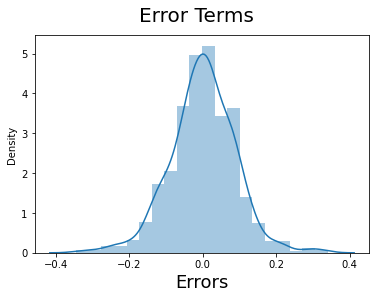

In [673]:
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
# Plot heading
fig.suptitle('Error Terms', fontsize = 20)    
# Give the X-label
plt.xlabel('Errors', fontsize = 18)

In [674]:
#scaling the df_test dataset
df_test[var] = scaler.transform(df_test[var])

In [675]:
# splitting the x_test with the predictor variables and y_test with SalePrice variables
X_test = df_test.drop(["SalePrice"],axis=1) 
y_test = df_test.pop('SalePrice')

In [676]:
# considering only the selected features from RFE
col2=m.columns

In [677]:
# filtering the X_test to contain only the selected features
X_test_rfe2 = X_test[col2]

In [678]:
# Adding a constant to the model
X_test_rfe2 = sm.add_constant(X_test_rfe2)

#predicting the y values
y_pred = lm11.predict(X_test_rfe2)

Text(0, 0.5, 'y_pred')

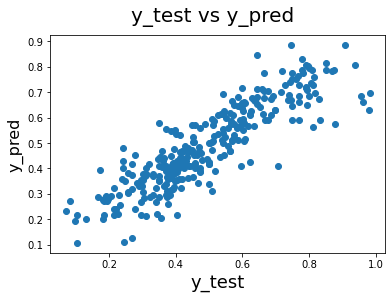

In [679]:
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              
plt.xlabel('y_test', fontsize = 18)                          
plt.ylabel('y_pred', fontsize = 16)  

## Residual Analysis on the training data

In [443]:
# Residual analysis
y_res = y_train - y_train_pred

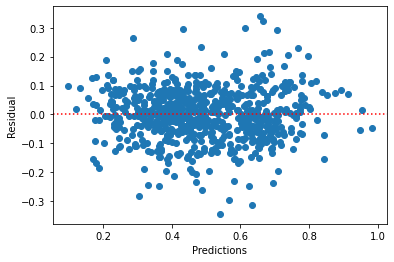

In [680]:
df_train['res'] = y_res
plt.scatter( y_train_pred , df_train['res'])
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.show()

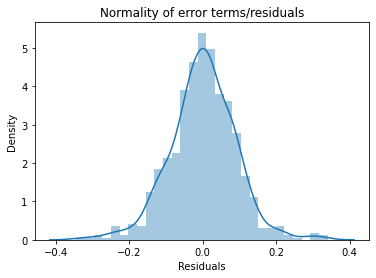

In [681]:
# Distribution of errors
p = sns.distplot(y_res,kde=True)

p = plt.title('Normality of error terms/residuals')
plt.xlabel("Residuals")
plt.show()

## Residual Analysis on the test data

In [682]:
# Residual analysis
y_res_test = y_test - y_pred
#y_res

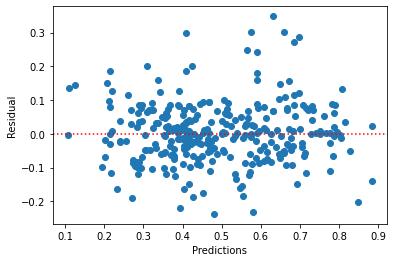

In [683]:
df_test['res'] = y_res_test
plt.scatter( y_pred , df_test['res'])
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.show()

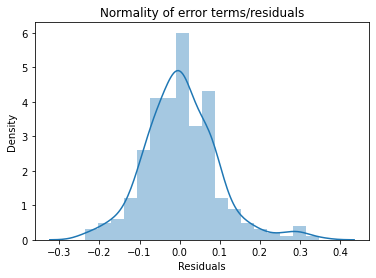

In [684]:
# Distribution of errors
p = sns.distplot(y_res_test,kde=True)

p = plt.title('Normality of error terms/residuals')
plt.xlabel("Residuals")
plt.show()

# Model building with Linear Regression, Ridge and Lasso

##  Linear Regression with all features

In [751]:
X_train.drop("Id",axis=1,inplace=True)
X_test.drop("Id",axis=1,inplace=True)

KeyError: "['Id'] not found in axis"

In [752]:
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [753]:
# displaying the coefs and the intercepts
print(lm.intercept_)
print(lm.coef_)

-0.16839576892390173
[ 2.03344359e-03  8.86472895e-02  3.83973560e-03  2.02827890e-02
 -2.86307196e-02  1.09987892e-01  3.73160278e-01  1.00220938e-02
  5.54363051e-02  3.26582164e-02 -1.54709954e-02  1.67321038e-02
  7.23399806e-02  1.54574567e-02  2.27004944e-02 -6.38600267e-03
 -1.73645219e-01  5.50284913e-03  2.08071475e-02  6.36001277e-02
  2.50705902e-02  2.80869953e-02  1.58348938e-02  3.80489566e-02
  4.69860101e-03  1.74341081e-02 -1.95296203e-02 -4.17799762e-02
  1.39935060e-01  1.38373449e-02  7.47683960e-02  6.78424599e-02
  4.69188720e-02 -9.83180163e-03  1.59816169e-02 -4.73776796e-02
 -2.12523697e-02 -1.18523053e-02 -6.31990309e-03  1.39298527e-02
  1.18547854e-01  9.95898308e-02  1.39919649e-01  1.06972213e-01
  1.35723143e-02 -4.17836587e-02  1.86725813e-02 -7.36274898e-03
  3.68716309e-02  3.04166723e-02  5.01637341e-02 -1.15168839e-02
 -1.60752754e-03  1.19824323e-01 -3.80419138e-02 -2.32177973e-02
  1.92296952e-02 -5.36306966e-02 -2.07445825e-02 -1.82632593e-02
 -7.

In [754]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9291516362440257
-6.110093613078432e+21
1.6843464175179799
6.767153336642952e+22
0.002359028595963557
2.2042844744765315e+20


## Ridge and Lasso Regression

#### Let's now try predicting car prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

## Ridge Regression

In [755]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [756]:
print(model_cv.best_params_)

{'alpha': 1.0}


In [757]:
alpha = 1.0
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 0.00359138  0.08408756  0.00758614  0.03606206 -0.00741185  0.10736574
  0.28661078  0.01168128  0.06807482  0.03615309  0.0024234   0.02051151
  0.07225081  0.01927691  0.02728915 -0.00383236 -0.12190195  0.00274391
  0.0376056   0.04721955  0.02393666  0.02861589  0.02144738  0.04292986
  0.00788248  0.01403947 -0.02038736 -0.02602931  0.03418347 -0.00115328
  0.0399326   0.02750999  0.01864785 -0.0059155   0.00053911 -0.03526037
 -0.02286778 -0.04475243 -0.00721744 -0.01209796  0.05322631  0.0313149
  0.08466806  0.06250947  0.01877741 -0.04207883  0.00938075 -0.00727076
  0.01792706  0.0008188   0.02948215  0.00128192 -0.00753305  0.1049959
 -0.04579973 -0.02915282 -0.01369259 -0.061994   -0.02571057 -0.02289791
  0.01169791 -0.03550048  0.06793017  0.05324507 -0.0169023  -0.04224252
 -0.02307887 -0.020236    0.05615418  0.03155882 -0.03143109  0.00210633
 -0.02408858  0.02141728  0.         -0.03050621 -0.03072316  0.00487012
  0.0133581  -0.0380569  -0.02597724 -0.00584019  0.0

In [758]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9253110197601153
0.8851001750861043
1.7756530938163393
1.272557808085713
0.002486909094980867
0.004145139440018609


In [759]:
ridge_df = pd.DataFrame({
    'columns': X_train.columns,
    'weight': ridge.coef_
}).sort_values('weight', ascending=False)
ridge_df

,columns,weight
6,GrLivArea,0.286611
5,TotalBsmtSF,0.107366
53,Neighborhood_Crawfor,0.104996
85,OverallQual_8,0.097396
42,MSZoning_RL,0.084668
1,LotArea,0.084088
12,GarageArea,0.072251
93,OverallCond_9,0.070329
8,FullBath,0.068075
62,Neighborhood_NoRidge,0.067930


### The significant features from Ridge regression are 
- GrLivArea
- TotalBsmtSF 
- Neighborhood_Crawfor
- OverallQual_8,
- MSZoning_RL

#### The R2 value of nearly 88% indicates that the above features explain a larger proportion of the variation in the response variable.


## Lasso

In [760]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [761]:
print(model_cv.best_params_)

{'alpha': 0.0001}


In [762]:
alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train)

Lasso(alpha=0.0001)

In [763]:
lasso.coef_

array([ 1.60163300e-03,  8.69483221e-02,  0.00000000e+00,  3.63912316e-02,
       -9.74927525e-03,  1.03813558e-01,  3.37632375e-01,  1.06276648e-02,
        5.31772453e-02,  3.03410040e-02, -0.00000000e+00,  2.00883620e-02,
        6.55178271e-02,  1.81652319e-02,  2.61706580e-02, -1.48489913e-03,
       -1.84747931e-01,  0.00000000e+00,  3.57684507e-02,  3.34083620e-02,
        2.45424404e-02,  2.75317439e-02,  1.65563359e-02,  3.73981966e-02,
        5.86465239e-03,  1.29412262e-02, -4.16002809e-03, -0.00000000e+00,
        1.85174547e-02, -8.94850202e-04,  2.76686981e-03,  7.86462447e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.71204086e-02,
       -1.05736590e-02, -6.69668578e-02, -0.00000000e+00, -1.70993754e-02,
        4.45750432e-02,  1.26038882e-02,  8.07785757e-02,  5.66972681e-02,
        1.82985445e-02, -3.62233718e-02,  0.00000000e+00, -5.03823629e-03,
        0.00000000e+00,  0.00000000e+00,  4.16081126e-02,  0.00000000e+00,
        2.47081168e-03,  

In [764]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9229167279780922
0.8925837286065116
1.8325748993704334
1.1896747012423543
0.002566631511723296
0.003875161893297571


In [765]:
lasso_df = pd.DataFrame({
    'columns': X_train.columns,
    'weight': lasso.coef_
}).sort_values('weight', ascending=False)
lasso_df

,columns,weight
6,GrLivArea,0.337632
53,Neighborhood_Crawfor,0.115010
5,TotalBsmtSF,0.103814
85,OverallQual_8,0.099221
1,LotArea,0.086948
93,OverallCond_9,0.081809
42,MSZoning_RL,0.080779
62,Neighborhood_NoRidge,0.072239
68,Neighborhood_Somerst,0.067501
12,GarageArea,0.065518


### The significant features from Lasso regression are 
- GrLivArea
- Neighborhood_Crawfor
- TotalBsmtSF
- OverallQual_8
- LotArea

#### The R2 value of nearly 89% indicates that the above features explain a larger proportion of the variation in the response variable.


In [766]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.291516e-01,0.925311,0.922917
1,R2 Score (Test),-6.110094e+21,0.885100,0.892584
2,RSS (Train),1.684346e+00,1.775653,1.832575
3,RSS (Test),6.767153e+22,1.272558,1.189675
4,MSE (Train),4.856983e-02,0.049869,0.050662
5,MSE (Test),1.484683e+10,0.064383,0.062251


### Calculating all the coefs with three regressions

In [767]:
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns

betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

pd.set_option('display.max_rows', None)
betas.head(68)

,Linear,Ridge,Lasso
LotFrontage,0.002033,0.003591,0.001602
LotArea,0.088647,0.084088,0.086948
MasVnrArea,0.003840,0.007586,0.000000
BsmtFinSF1,0.020283,0.036062,0.036391
BsmtUnfSF,-0.028631,-0.007412,-0.009749
TotalBsmtSF,0.109988,0.107366,0.103814
GrLivArea,0.373160,0.286611,0.337632
BsmtFullBath,0.010022,0.011681,0.010628
FullBath,0.055436,0.068075,0.053177
HalfBath,0.032658,0.036153,0.030341


### The optimal values of lambda for Ridge and Lasso regression are 1.0 and 0.0001 respectively

# Model with double the value of alpha for both Ridge and Lasso regression

## Ridge 

In [724]:
alpha = 2.0
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 4.55260266e-03  7.83632041e-02  9.11790655e-03  4.32018877e-02
  3.94648079e-03  1.03060845e-01  2.42905047e-01  1.25252295e-02
  7.22797160e-02  3.77081174e-02  1.14138376e-02  2.15253991e-02
  7.30452116e-02  2.02709730e-02  2.94125963e-02 -3.15900728e-03
 -9.79594544e-02 -5.46920505e-05  4.24525902e-02  4.07057739e-02
  2.28742375e-02  2.90479392e-02  2.46547665e-02  4.54056017e-02
  1.07742012e-02  1.40651110e-02 -2.07500616e-02 -1.76983027e-02
  1.81768931e-02 -4.51576942e-04  3.52305880e-02  2.12790476e-02
  1.27936008e-02 -1.57775039e-03 -5.82796541e-04 -2.55927416e-02
 -1.99476147e-02 -4.81246317e-02 -4.30719501e-03 -1.40479844e-02
  3.84996140e-02  1.34586621e-02  6.89499783e-02  4.69360496e-02
  2.06589118e-02 -3.97402672e-02  7.71722440e-03 -6.82567391e-03
  1.45405504e-02 -2.95088304e-03  2.67368230e-02  4.75787611e-03
 -5.34408081e-03  9.94272427e-02 -4.40732564e-02 -2.73404027e-02
 -1.96985936e-02 -5.62376254e-02 -2.23555823e-02 -2.02945703e-02
  9.60121696e-03 -3.03866

In [725]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9217036818382172
0.8868268171337099
1.8614138140843988
1.2534346125447597
0.002607022148577589
0.004082848900797263


In [726]:
ridge_df = pd.DataFrame({
    'columns': X_train.columns,
    'weight': ridge.coef_
}).sort_values('weight', ascending=False)
ridge_df

,columns,weight
6,GrLivArea,0.242905
5,TotalBsmtSF,0.103061
53,Neighborhood_Crawfor,0.099427
85,OverallQual_8,0.093164
1,LotArea,0.078363
12,GarageArea,0.073045
8,FullBath,0.072280
42,MSZoning_RL,0.068950
62,Neighborhood_NoRidge,0.062766
93,OverallCond_9,0.058072


### The significant features from Ridge regression are 
- GrLivArea
- TotalBsmtSF 
- Neighborhood_Crawfor
- OverallQual_8,
- LotArea

#### The R2 value of nearly 88% indicates that the above features explain a larger proportion of the variation in the response variable.


## Lasso

In [727]:
alpha =0.0002

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train)

Lasso(alpha=0.0002)

In [728]:
lasso.coef_

array([ 0.00000000e+00,  8.43838025e-02,  0.00000000e+00,  4.37957559e-02,
       -0.00000000e+00,  1.03145121e-01,  3.25727646e-01,  1.02755693e-02,
        4.91874946e-02,  3.06373009e-02, -0.00000000e+00,  1.98161656e-02,
        6.42252987e-02,  1.67960122e-02,  2.48433776e-02, -0.00000000e+00,
       -1.82720678e-01,  0.00000000e+00,  3.52986172e-02,  1.55303920e-02,
        2.07784783e-02,  2.76060380e-02,  1.84780275e-02,  4.15790128e-02,
        7.55246932e-03,  1.50140452e-02, -0.00000000e+00, -0.00000000e+00,
        4.04070925e-03, -0.00000000e+00,  1.94976879e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.40365879e-02,
       -0.00000000e+00, -6.20949480e-02, -0.00000000e+00, -1.34635997e-02,
        1.63995612e-02,  0.00000000e+00,  5.95180619e-02,  3.23264650e-02,
        1.98983587e-02, -2.80508386e-02,  0.00000000e+00, -3.30459383e-03,
        0.00000000e+00,  0.00000000e+00,  4.55804380e-02,  0.00000000e+00,
        9.42550193e-03,  

In [729]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9178509711459821
0.8983403954630232
1.9530080176506333
1.1259174991553018
0.0027353053468496262
0.003667483710603589


In [730]:
lasso_df = pd.DataFrame({
    'columns': X_train.columns,
    'weight': lasso.coef_
}).sort_values('weight', ascending=False)
lasso_df

,columns,weight
6,GrLivArea,0.325728
53,Neighborhood_Crawfor,0.113965
85,OverallQual_8,0.103760
5,TotalBsmtSF,0.103145
1,LotArea,0.084384
93,OverallCond_9,0.074163
68,Neighborhood_Somerst,0.073974
62,Neighborhood_NoRidge,0.068426
12,GarageArea,0.064225
91,OverallCond_7,0.059835


### The significant features from Lasso regression are 
- GrLivArea
- Neighborhood_Crawfor
- OverallQual_8
- TotalBsmtSF
- LotArea

#### The R2 value of nearly 89% indicates that the above features explain a larger proportion of the variation in the response variable.


In [731]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.291516e-01,0.921704,0.917851
1,R2 Score (Test),-6.110094e+21,0.886827,0.898340
2,RSS (Train),1.684346e+00,1.861414,1.953008
3,RSS (Test),6.767153e+22,1.253435,1.125917
4,MSE (Train),4.856983e-02,0.051059,0.052300
5,MSE (Test),1.484683e+10,0.063897,0.060560


# Lasso Model with excluding import features

In [768]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 391 to 722
Columns: 138 entries, LotFrontage to GarageType_None
dtypes: float64(26), uint8(112)
memory usage: 228.7 KB


In [782]:
col_list=[]
for col in X_train.columns:
    if col.startswith('OverallQual'):
        col_list.append(col)
    elif col.startswith('Neighborhood'):
        col_list.append(col)
col_list

['Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Neighborhood_Veenker',
 'OverallQual_2',
 'OverallQual_3',
 'OverallQual_4',
 'OverallQual_5',
 'OverallQual_6',
 'OverallQual_7',
 'OverallQual_8']

In [783]:
col_list.append('GrLivArea')
col_list.append('TotalBsmtSF')
col_list.append('LotArea')

In [784]:
X_train_new=X_train.drop(columns=col_list,axis=1)

In [785]:
X_test_new=X_test.drop(columns=col_list,axis=1)

In [786]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_new, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [787]:
print(model_cv.best_params_)

{'alpha': 0.0001}


In [788]:
alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_new, y_train)

Lasso(alpha=0.0001)

In [789]:
lasso.coef_

array([ 0.01788718,  0.04231875,  0.15197444,  0.15720907,  0.01966959,
        0.13009002,  0.06678406,  0.06155069,  0.03201769,  0.13867212,
        0.01860073,  0.03977042,  0.0023768 , -0.06780403, -0.02050599,
        0.14905353,  0.06321932,  0.03857795,  0.02755348,  0.0365543 ,
        0.0549209 ,  0.03849757,  0.        , -0.00955546,  0.        ,
        0.        ,  0.01410564,  0.00068611,  0.05301815,  0.02509899,
       -0.        ,  0.        , -0.0043939 , -0.00031386, -0.09430845,
       -0.01169055, -0.02362908,  0.11646846,  0.01238409,  0.10117298,
        0.05852797,  0.03718353, -0.04228114,  0.        , -0.00890245,
       -0.        , -0.01970213,  0.        ,  0.01967271, -0.        ,
       -0.06342928, -0.02683743, -0.03255419, -0.07130228, -0.03772414,
       -0.        ,  0.0092421 ,  0.04490396,  0.03320173,  0.04777092,
       -0.0509245 ,  0.00915103, -0.03997142,  0.        ,  0.        ,
       -0.05969445,  0.04205442, -0.        ,  0.        , -0.00

In [790]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train_new)
y_pred_test = lasso.predict(X_test_new)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8581234415966561
0.8203382026046848
3.3729681280931745
1.9898204654485232
0.004724044997329376
0.006481499887454473


In [791]:
lasso_df = pd.DataFrame({
    'columns': X_train_new.columns,
    'weight': lasso.coef_
}).sort_values('weight', ascending=False)
lasso_df

,columns,weight
3,BsmtUnfSF,0.157209
2,BsmtFinSF1,0.151974
15,ExterQual_cat,0.149054
9,GarageArea,0.138672
5,FullBath,0.130090
37,MSZoning_FV,0.116468
39,MSZoning_RL,0.101173
72,Exterior1st_Stucco,0.083052
95,Foundation_Slab,0.073156
6,HalfBath,0.066784


### The significant features from Lasso regression are 
- BsmtUnfSF
- BsmtFinSF1
- ExterQual_cat
- GarageArea
- FullBath

#### The R2 value of nearly 82% indicates that the above features explain a larger proportion of the variation in the response variable.
